# Development Notebook

This notebook is intended to develop and test some code required for the **iWander** package.  Due to its nature it cannot be executed sequentially.

Some of the codes used here when mature are converted into routines in the dev/analysis.py 

In [8]:
from iwander import *

## Global definitions

In [58]:
BD="../"
%matplotlib inline

## Elements of surrogate objects

In [254]:
wobjs=pd.read_csv(BD+"wanderer.csv")
nominal=wobjs.iloc[0]

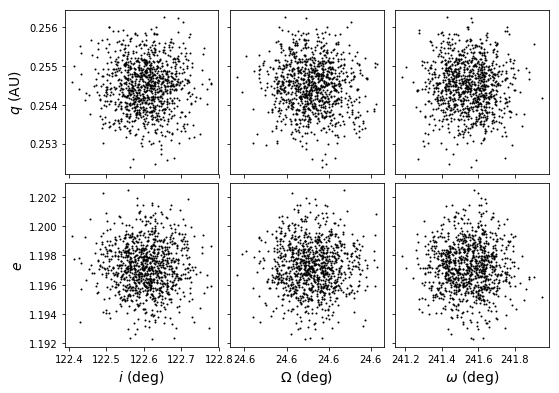

In [255]:
fig,axs=subPlots([1,1],l=0.12,b=0.2,ncols=3,dh=0.02,dw=0.02,figsize=(8,3))
args=dict(marker='o',color='k',ms=1,lw=0)
fsize=14

ax=axs[0][0]
ax.plot(wobjs.inco*RAD,wobjs.eo,**args)
ax.set_ylabel(r'$e$',fontsize=fsize)
ax.set_xlabel(r'$i$ (deg)',fontsize=fsize)

ax=axs[1][0]
ax.plot(wobjs.Wo*RAD,wobjs.eo,**args)
ax.set_xlabel(r'$\Omega$ (deg)',fontsize=fsize)
ax.set_yticklabels([])

ax=axs[2][0]
ax.plot(wobjs.wo*RAD,wobjs.eo,**args)
ax.set_xlabel(r'$\omega$ (deg)',fontsize=fsize)
ax.set_yticklabels([])

for ax in axs[0][0],axs[1][0],axs[2][0]:
    ax.tick_params(axis='both',which='major',labelsize=10)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax=axs[0][1]
ax.plot(wobjs.inco*RAD,wobjs.qo/AU,**args)
ax.set_ylabel(r'$q$ (AU)',fontsize=fsize)
ax.set_xticklabels([])

ax=axs[1][1]
ax.plot(wobjs.Wo*RAD,wobjs.qo/AU,**args)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax=axs[2][1]
ax.plot(wobjs.wo*RAD,wobjs.qo/AU,**args)
ax.set_xticklabels([])
ax.set_yticklabels([])

fig.savefig(FIGDIR+"wanderer-elements-diagonal.png")

## Development area

Since **iwander.py** library cannot be updated, while developing all global definitions and codes should be written in the following area

In [236]:
from matplotlib.ticker import FormatStrFormatter

#CONSTANTS
AU=1.496e8 #km

DEG=np.pi/180
RAD=1/DEG

FIGDIR="figures/"

#ROUTINES
def figure(qax=True,**figopts):
    default=dict(qax=True)
    fig=plt.figure(**figopts)
    if qax:ax=fig.add_subplot(111)
    else:ax=None
    return fig,ax

def subPlots(panels,ncols=1,l=0.1,b=0.1,w=0.8,figsize=(8,6),dh=None,dw=None,fac=2.0):
    """
    Subplots
    """
    import numpy
    npanels=len(panels)
    spanels=sum(panels)

    # GET SIZE OF PANELS
    b=b/npanels
    if dh is None:dh=[b/2]*npanels
    elif type(dh) is not list:dh=[dh]*npanels
    else:
        dh+=[0]

    if dw is None:dw=w/5
        
    # EFFECTIVE PLOTTING REGION
    hall=(1-fac*b-sum(dh))
    hs=(hall*numpy.array(panels))/spanels
    fach=(1.0*max(panels))/spanels

    # SEE IF THERE IS MORE THAN ONE COLUMN
    wc=w/ncols if ncols>1 else w
    
    # CREATE AXES
    fig=plt.figure(figsize=(figsize[0],figsize[1]/fach))
    axs=[]
    
    bo=b
    axc=[]
    for i in range(npanels):
        ax=fig.add_axes([l,b,wc,hs[i]])
        axc+=[ax]
        b+=hs[i]+dh[i]
    axs+=[axc]
        
    b=bo
    if ncols>1:
        for j in range(ncols-1):
            b=bo
            l+=wc+dw
            axc=[]
            for i in range(npanels):
                ax=fig.add_axes([l,b,wc,hs[i]])
                axc+=[ax]
                b+=hs[i]+dh[i]
            axs+=[axc]
            
    return fig,axs